# Phase de Features engeniering et preprocessing


## Import librairies

In [1]:
import sys
from pathlib import Path
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import os
import locale
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ajouter le dossier parent src au path
sys.path.append(os.path.abspath('..'))

%matplotlib inline


## CONSTANTES

In [2]:
EXTRACT_DATE = datetime(2025, 11, 1, 17, 2, 28)

PRICE_SEGMENTS = [
    {
        "label": "0 - 7.99",
        "value_min": 0,
        "value_max": 7.99,
    },
    {
        "label": "8 - 14.99",
        "value_min": 8,
        "value_max": 14.99,
    },
    {
        "label": "15 - 24.99",
        "value_min": 15,
        "value_max": 24.99,
    },
    {
        "label": "25 - 39.99",
        "value_min": 25,
        "value_max": 39.99,
    },
    {
        "label": "40+",
        "value_min": 40,
        "value_max": 150,
    },
]

PROMOS = [10,25,33,50,75]


## Chargement du dataset

In [3]:
# Fichier stocké temporairement sur un de mes S3
# url = "https://d3aok2axxchxf9.cloudfront.net/ia/games_data.csv"

url = os.path.join(Path.cwd().parent, "data/processed/games_data.csv")

# Charger les données CSV, Les colonnes Boolean sont au format Int64 (0,1,NaN)
df = pd.read_csv(url,dtype={
    'trophies_count': 'Int64',
    'local_multiplayer_max_players': 'Int64',
    'online_multiplayer_max_players': 'Int64',
    'difficulty': 'Int64',
    'download_size': 'Int64',
    'hours_main_story': 'Int64',
    'hours_completionist': 'Int64',
    'metacritic_critic_score': 'Int64',
    'metacritic_critic_userscore': 'Int64',
    'pegi_rating': 'Int64',
})


## Vérification des données chargées

In [4]:
def column_summary(df:pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        unique_count = df[col].nunique()

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    return pd.DataFrame(summary)

# Afficher le résumé des colonnes
print("=" * 80)
print("Résumé détaillé des colonnes:")
print("=" * 80)
column_summary_df = column_summary(df)
print(column_summary_df.to_string(index=False))
print("\n")

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
                     game_name  object            5382           0           5382
                      id_store  object            5382           0           5382
                short_url_name  object            5382           0           5382
                     publisher  object            5382           0           1083
                     developer  object            3920        1462           2709
                  release_date  object            5382           0           1347
         pssstore_stars_rating float64            5382           0            352
   pssstore_stars_rating_count   int64            5382           0           1583
       metacritic_critic_score   Int64            1268        4114             67
   metacritic_critic_userscore   Int64            1268        4114             10
                        genres  object            5360          22  

In [5]:
df.head()

,game_name,id_store,short_url_name,publisher,developer,release_date,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,...,hours_main_story,hours_completionist,pegi_rating,esrb_rating,rating_descriptions,voice_languages,subtitle_languages,base_price,lowest_price,price_history
0,"#Halloween, Super Puzzles Dream",EP8311-PPSA19174_00-0421646910657705,game-halloween-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-10-30,1.57,14,<NA>,<NA>,...,<NA>,<NA>,7,Everyone,Fear/Horror,NaN,NaN,4.99,1.49,"[{""x"": ""2023-11-02"", ""y"": 4.99}, {""x"": ""2023-1..."
1,#SinucaAttack,EP2005-PPSA06055_00-SINUCA0000000000,game-sinucaattack-ps5,eastasiasoft,NaN,2022-05-19,3.26,72,<NA>,<NA>,...,0,0,3,Everyone,Fantasy Violence,NaN,NaN,4.99,1.49,"[{""x"": ""2022-05-21"", ""y"": 4.99}, {""x"": ""2022-1..."
2,"#Wish travel, super puzzle dreams",EP8311-PPSA16513_00-0233078860249892,game-wish-travel-super-puzzle-dreams-ps5,e-llusiontertainment,NaN,2023-05-31,1.55,11,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-06-19"", ""y"": 4.99}, {""x"": ""2023-0..."
3,"#WomenUp, Super Puzzles Dream",EP8311-PPSA13840_00-0277389480637871,game-womenup-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-01-26,1.44,18,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-05-21"", ""y"": 4.99}, {""x"": ""2023-0..."
4,"#Xmas, Super Puzzles Dream",EP8311-PPSA12662_00-0212989199890961,game-xmas-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2022-12-22,1.17,23,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-01-23"", ""y"": 4.99}, {""x"": ""2023-0..."


In [6]:
df.describe()

,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,is_ps4,is_ps5,is_indie,is_dlc,is_vr,is_opti_ps5_pro,...,has_online_multiplayer,online_multiplayer_max_players,is_online_only,difficulty,download_size,hours_main_story,hours_completionist,pegi_rating,base_price,lowest_price
count,5382.000000,5.382000e+03,1268.0,1268.0,5382.000000,5382.0,5382.000000,5382.0,5382.000000,5382.000000,...,5382.000000,5382.0,5382.000000,2427.0,2528.0,3353.0,2905.0,4562.0,5382.000000,5382.000000
mean,3.862824,3.501787e+03,57.87224,59.124606,0.447046,1.0,0.423820,0.0,0.050353,0.028428,...,0.143627,1.196024,0.020810,3.416976,6334336842.530854,10.283925,11.456454,8.772907,18.526524,9.020821
std,0.691182,3.622325e+04,30.002306,20.191043,0.497234,0.0,0.494208,0.0,0.218693,0.166208,...,0.350744,6.523387,0.142761,2.614881,15086547791.580881,28.962312,44.02705,5.475559,16.451834,9.519553
min,0.000000,0.000000e+00,3.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,1.0,327679.0,0.0,0.0,3.0,1.190000,0.540000
25%,3.520000,3.100000e+01,45.75,50.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,2.0,225771520.0,1.0,1.0,3.0,5.990000,2.490000
50%,4.000000,8.800000e+01,71.0,60.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,3.0,886177792.0,5.0,5.0,7.0,14.990000,5.990000
75%,4.360000,4.610000e+02,79.0,70.0,1.000000,1.0,1.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,4.0,4170399744.0,11.0,12.0,12.0,24.990000,11.990000
max,5.000000,1.825682e+06,96.0,90.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,...,1.000000,99.0,1.000000,11.0,147972947968.0,1000.0,1500.0,18.0,94.990000,79.990000


### Plots utils

In [7]:
def draw_binary_circular_plots(data: list, name: str, axe: plt.Axes):
    colors = sns.color_palette("crest")
    values = [item["value"] for item in data]
    labels = [item["label"] for item in data]

    wedges, texts, autotexts = axe.pie(
        values,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        shadow=False,
    )

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    axe.set_title(f"{name}", fontweight="bold", pad=20)
    
    
def layout_plots(n_cols: int):
    # Calculer le nombre de lignes nécessaires
    actual_rows = (n_cols + 2) // 3  # 3 colonnes par ligne

    # Limiter à 3 colonnes maximum
    actual_cols = min(n_cols, 3)

    # Créer la figure avec plus d'espace vertical
    fig, axes = plt.subplots(
        actual_rows, 
        actual_cols, 
        figsize=(12, 5 * actual_rows),  # Hauteur dynamique selon le nombre de lignes
        gridspec_kw={'hspace': 0.5, 'wspace': 0.3}  # ← Espace entre les lignes/colonnes
    )

    # Normaliser axes pour toujours retourner un tableau 1D itérable
    if n_cols == 1:
        axes = [axes]
    elif actual_rows == 1 and actual_cols == 1:
        axes = [axes]
    elif actual_rows == 1:
        axes = list(axes)
    else:
        axes = list(axes.flatten())

    return fig, axes

def generate_multi_str_col_top_proportion_data(
    df: pd.DataFrame, col_name: str, top_count: int
):

    # Séparer les genres et exploser
    genres_exploded = df[col_name].str.split(",").explode()
    genres_exploded = genres_exploded.str.strip()
    genre_counts = genres_exploded.value_counts()

    # Garder le top 6 et regrouper le reste dans "Autres"
    top_val = genre_counts.head(top_count)
    autres = genre_counts.iloc[top_count:].sum()

    # Créer les données finales
    if autres > 0:
        final_counts = pd.concat([top_val, pd.Series({"Autres": autres})])
    else:
        final_counts = top_val

    result = []
    for label, value in final_counts.items():
        result.append(
            {
                "label": label,
                "value": value,
            }
        )

    return result

## FEATURE ENGINEERING

### Retour métier des consultants sur la prédiction du nombre de jours avant baisse de prix

- **Temporalité de sortie concurrentes :** C'est une feature que je pourrai peut être extraire du dataset (pour une fenêtre de date commune, lister le nombre de jeux avec même genre et de de niveau AAA) . Mais une analyse humaine semble importante.

- **Prix peut baisser plus rapidement s’il s’agit d’un Remastered:** c'est une information que je peux retrouver dans le nom du jeu.

- **Les jeux dont le succès à une incidence sur la pérénité du studio:** C'est une feature que je vais intégrer dans ma prédiction, pour un jeu avoir l'information si le studio de developpement et l'éditeur sont important dans l'industrie:

  - MAJEURE (SONY, CAPCOM, UBISOFT etc)
  - ACTIF (nombre de jeux > 3 par exemple)
  - AUTRES

- **Cycle console:** jeux sortie au debut, milieu ou fin de vie de la console
  - C'est une feature que je peux déduire des données et intégrer (en fonction de la date de sortie de la console PS4 et sortie PS5)

- **Nombre de DLCs:** La sortie d'une extension va forcement avoir une incidence sur le prix du jeu de base
  - Le nombre de DLCs sortie est présent dans les données
  - Je pourrai trouver les dates de sortie d'une extension d'un jeu si j'avais plus de temps de developpement.

- **Le jeu contient-il des microtransactions:** Achat in game rentable on peut se permettre de baisser le prix du jeu de base rapidement
  - Le nombre de microtransactions disponible à l'achat pour un jeu est présent dans les données

- **Fait-il parti d'une série de suite:** Typiquement les jeux de sport annuelle
  - Le nombre de jeux faisant partis de la même série est présent dans les données. (FIFA 2022 - FIFA 2023 etc.)

- **Exclusivité ps5** Le prix aura tendance à moins baisser (il faut que le jeu soit rentable, on peut pas se rattraper sur les ventes des jeux des autres consoles / pc)
  - L'information est présente dans les données

### Création features

Transformation des dates en nombre de jours avant réduction

In [8]:
# Convertir la colonne price_history de string vers list
df['price_history'] = df['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

def days_until_first_discount(
    sales_history, base_price, release_date, discount_threshold=0
):
    if release_date is None:
        return None

    if len(sales_history) == 0:
        return None

    if not isinstance(base_price, (int, float)):
        return None

    # Convertir release_date en datetime si c'est une string
    if isinstance(release_date, str):
        release_date = datetime.strptime(release_date, "%Y-%m-%d")

    # Calculer le prix cible selon le seuil de réduction
    target_price = base_price * (1 - discount_threshold / 100)

    # Parcourir l'historique pour trouver la première baisse atteignant le seuil
    for entry in sales_history:
        price = entry["y"]
        date_str = entry["x"]
        date = datetime.strptime(date_str, "%Y-%m-%d")

        # Ignorer les prix négatifs
        if price < 0.1:
            continue

        # Vérifier si la réduction atteint le seuil et après la date de sortie
        if price <= target_price and date >= release_date:
            days_diff = (date - release_date).days
            return days_diff

    # Aucune baisse au seuil voulu trouvée
    return None

for promo in PROMOS:
    col_name = f'days_to_{promo}_percent_discount'
    df[col_name] = df.apply(
        lambda row: days_until_first_discount(
            row['price_history'], 
            row['base_price'], 
            row['release_date'], 
            promo
        ),
        axis=1
    )
    
# Calculer l'ancienneté de chaque jeu
df['release_date_dt'] = pd.to_datetime(df['release_date'])

df['days_since_release'] = (EXTRACT_DATE - df['release_date_dt']).dt.days

# Afficher un résumé des nouvelles colonnes
new_cols = [f'days_to_{p}_percent_discount' for p in PROMOS]
new_cols += ['days_since_release']

print(df[new_cols].describe())

summary_data = []
for promo in PROMOS:
    col = f'days_to_{promo}_percent_discount'
    summary_data.append({
        'Réduction': f'-{promo}%',
        'Jeux concernés': df[col].notna().sum(),
        'Pourcentage': f"{(df[col].notna().sum() / len(df)) * 100:.1f}%",
        'Médiane (jours)': df[col].median(),
        'Moyenne (jours)': df[col].mean(),
        'Min (jours)': df[col].min(),
        'Max (jours)': df[col].max()
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("RÉSUMÉ DES PROMOTIONS")
print("="*80)
print(summary_df.to_string(index=False))


       days_to_10_percent_discount  days_to_25_percent_discount  \
count                  4778.000000                  4509.000000   
mean                    111.046463                   139.444666   
std                     114.792521                   130.566226   
min                       0.000000                     0.000000   
25%                      48.000000                    57.000000   
50%                      76.000000                    98.000000   
75%                     128.000000                   175.000000   
max                    1292.000000                  1292.000000   

       days_to_33_percent_discount  days_to_50_percent_discount  \
count                  3714.000000                  3091.000000   
mean                    205.792138                   290.918149   
std                     159.093618                   207.714124   
min                       0.000000                     0.000000   
25%                      97.000000                   142.0000

## Filtrer les jeux récent sans baisse de prix

In [ ]:
def filter_recent_games_without_discount(df: pd.DataFrame, months: int = 12) -> pd.DataFrame:
    """
    Enlève les jeux récents (< months mois) qui n'ont pas encore eu de baisse
    """
    df_copy = df.copy()
    
    # Convertir release_date
    df_copy['release_date'] = pd.to_datetime(df_copy['release_date'])
    
    # Date de référence
    cutoff_date = datetime.now() - timedelta(days=months * 30)
    
    # Filtrer
    df_filtered = df_copy[
        (df_copy['days_to_25_percent_discount'].notna()) |  # A eu une baisse
        (df_copy['release_date'] < cutoff_date)             # OU ancien
    ]
    
    # Stats
    removed = len(df) - len(df_filtered)
    print(f"📊 Filtrage des jeux récents sans baisse:")
    print(f"   Jeux avant: {len(df)}")
    print(f"   Jeux après: {len(df_filtered)}")
    print(f"   Supprimés: {removed} ({removed/len(df)*100:.1f}%)")
    
    return df_filtered

# Enlever les jeux récents du dataframe qui n'on pas encore eu de baisse < 1 an
# df_filtered = filter_recent_games_without_discount(df)


📊 Filtrage des jeux récents sans baisse:
   Jeux avant: 5382
   Jeux après: 4701
   Supprimés: 681 (12.7%)


## Création des Features

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    df_model = df.copy()
    
    # 1. Traiter les dates
    df_model['release_date'] = pd.to_datetime(df_model['release_date'])
    df_model['release_year'] = df_model['release_date'].dt.year
    df_model['release_month'] = df_model['release_date'].dt.month
    
    # df_model['release_quarter'] = df_model['release_date'].dt.quarter
    
    # Est-ce une sortie pendant les fêtes ?
    df_model['is_holiday_release'] = df_model['release_month'].isin([11, 12]).astype(int)
    
    # Catégories de prix
    df_model['price_category'] = pd.cut(
        df_model['base_price'], 
        bins=[0, 20, 40, 60, 100],
        labels=['budget', 'mid', 'premium', 'aaa']
    )
    
    # Score composite de qualité 
    df_model['quality_score'] = (
        df_model['pssstore_stars_rating'].fillna(0) * 20 +  # Normaliser sur 100
        df_model['metacritic_critic_score'].fillna(0)
    ) / 2
    
    # Popularité (log pour gérer les outliers)
    df_model['popularity_log'] = np.log1p(df_model['pssstore_stars_rating_count'].fillna(0))
    
    # Engagement du contenu
    df_model['has_extended_content'] = (
        (df_model['dlcs_count'] > 0) | 
        (df_model['has_microtransactions'] == 1)
    ).astype(int)
    
    # Durée de jeu (gérer les NaN)
    df_model['gameplay_hours'] = df_model['hours_main_story'].fillna(
        df_model['hours_completionist'].fillna(10)
    )
    df_model['hours_category'] = pd.cut(
        df_model['gameplay_hours'],
        bins=[0, 5, 15, 30, 100],
        labels=['short', 'medium', 'long', 'very_long']
    )
    
    # Type de jeu
    df_model['game_type'] = 'standard'
    df_model.loc[df_model['is_indie'] == 1, 'game_type'] = 'indie'
    df_model.loc[df_model['base_price'] > 60, 'game_type'] = 'aaa'
    df_model.loc[df_model['is_online_only'] == 1, 'game_type'] = 'online'
    
    # Exploser les genres (one-hot encoding)
    # Créer des colonnes binaires pour les genres principaux
    main_genres = ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 
                   'Sports', 'Racing', 'Fighting', 'Shooter']
    
    for genre in main_genres:
        df_model[f'genre_{genre.lower()}'] = df_model['genres'].str.contains(
            genre, case=False, na=False
        ).astype(int)
    
    # Nombre total de genres (diversité)
    df_model['genre_count'] = df_model['genres'].str.split(',').str.len()
    
    # Interaction prix x qualité
    df_model['price_quality_ratio'] = df_model['base_price'] / (df_model['quality_score'] + 1)
    
    # Platform features
    df_model['is_cross_gen'] = ((df_model['is_ps4'] == 1) & (df_model['is_ps5'] == 1)).astype(int)
    
    return df_model

df_features = prepare_features(df)

## Peprocessing

## AFC

## Premier test regression

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

promo_to_predict = 'days_to_25_percent_discount'

# Filtrer pour l'entraînement (uniquement jeux avec discount connu)
df_train = df_features[df_features[promo_to_predict].notna()].copy()

# Features à utiliser
feature_columns = [
    'base_price',
    'quality_score',
    'popularity_log',
    'release_year',
    'release_month',
    'release_quarter',
    'is_holiday_release',
    'gameplay_hours',
    'genre_count',
    'price_quality_ratio',
    'is_indie',
    'is_ps_exclusive',
    'is_online_only',
    'has_online_multiplayer',
    'has_local_multiplayer',
    'has_extended_content',
    'dlcs_count',
    'trophies_count',
    'is_cross_gen',
    'is_vr',
    'difficulty',
    'days_to_first_price_record',
    # Genres
    'genre_action', 'genre_adventure', 'genre_rpg', 
    'genre_strategy', 'genre_simulation', 'genre_sports',
]

# Filtrer les colonnes qui existent
feature_columns = [col for col in feature_columns if col in df_train.columns]

X = df_train[feature_columns].fillna(0)
y = df_train[promo_to_predict]

# Encoder les variables catégorielles si nécessaire
from sklearn.preprocessing import LabelEncoder

if 'price_category' in X.columns:
    le = LabelEncoder()
    X['price_category'] = le.fit_transform(X['price_category'].astype(str))

if 'hours_category' in X.columns:
    le = LabelEncoder()
    X['hours_category'] = le.fit_transform(X['hours_category'].astype(str))

if 'game_type' in X.columns:
    X = pd.get_dummies(X, columns=['game_type'], drop_first=True)


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 features les plus importantes:")
print(feature_importance.head(10))

# Score
y_pred = model.predict(X_test)
print(f"\nMAE: {mean_absolute_error(y_test, y_pred):.2f} jours")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

Top 10 features les plus importantes:
                feature  importance
3          release_year    0.201600
2        popularity_log    0.132804
8   price_quality_ratio    0.106895
16       trophies_count    0.094237
1         quality_score    0.089135
6        gameplay_hours    0.061242
0            base_price    0.060473
17         is_cross_gen    0.048914
4         release_month    0.044907
15           dlcs_count    0.027324

MAE: 75.46 jours
R²: 0.196


In [12]:
days_data = df[df[promo_to_predict].notna()][promo_to_predict]

print(f"Moyenne: {days_data.mean():.0f} jours")
print(f"Médiane: {days_data.median():.0f} jours")
print(f"Écart-type: {days_data.std():.0f} jours")
print(f"Min: {days_data.min():.0f} jours")
print(f"Max: {days_data.max():.0f} jours")

Moyenne: 139 jours
Médiane: 98 jours
Écart-type: 131 jours
Min: 0 jours
Max: 1292 jours


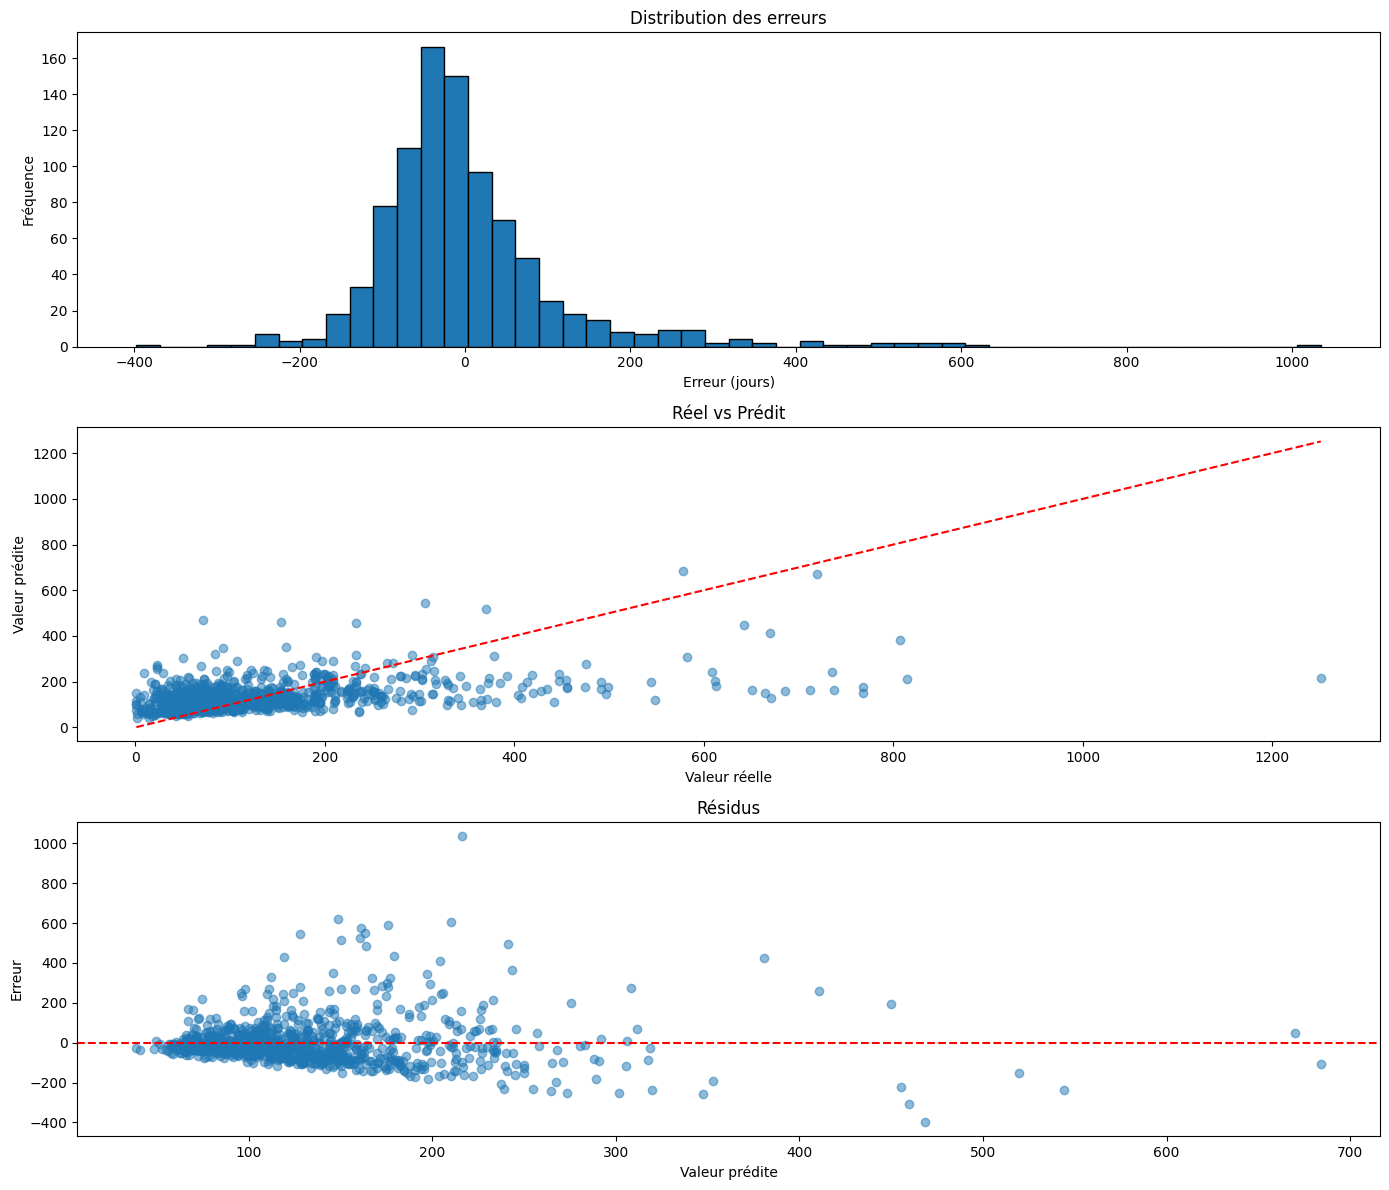

MAE: 75.46 jours
Médiane erreur absolue: 51.22 jours
RMSE: 117.18 jours
R²: 0.196
MAE / Moyenne cible: 54.9%


In [13]:
# 1. Vérifier la distribution des erreurs
import matplotlib.pyplot as plt

errors = y_test - y_pred
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(14, 12))
ax1: plt.Axes
ax2: plt.Axes
ax3: plt.Axes

ax1.hist(errors, bins=50, edgecolor='black')
ax1.set_xlabel('Erreur (jours)')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des erreurs')

ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_xlabel('Valeur réelle')
ax2.set_ylabel('Valeur prédite')
ax2.set_title('Réel vs Prédit')

ax3.scatter(y_pred, errors, alpha=0.5)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_xlabel('Valeur prédite')
ax3.set_ylabel('Erreur')
ax3.set_title('Résidus')

plt.tight_layout()
plt.show()

# 2. Métriques additionnelles
from sklearn.metrics import mean_squared_error, median_absolute_error

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} jours")
print(f"Médiane erreur absolue: {median_absolute_error(y_test, y_pred):.2f} jours")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} jours")
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE / Moyenne cible: {mean_absolute_error(y_test, y_pred) / y_test.mean() * 100:.1f}%")

In [14]:
# 1. Tester d'autres modèles
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# XGBoost souvent meilleur
xgb_model = XGBRegressor(n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:absoluteerror')

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")

# 2. Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"Meilleurs params: {grid_search.best_params_}")

# 3. Ajouter plus de features engineering
# - Interaction entre features importantes
# - Encoder publisher/developer avec target encoding
# - Ajouter des features temporelles (jours depuis release, saison, etc.)

XGBoost MAE: 71.99
Meilleurs params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [15]:
# Calculer votre ratio
mae = mean_absolute_error(y_test, y_pred)
mean_target = y_test.mean()
ratio = (mae / mean_target) * 100

print(f"MAE: {mae:.2f} jours")
print(f"Moyenne cible: {mean_target:.2f} jours")
print(f"MAE / Moyenne: {ratio:.1f}%")

# Interprétation
if ratio < 10:
    print("🌟 Excellent modèle!")
elif ratio < 20:
    print("✅ Bon modèle, utilisable en production")
elif ratio < 30:
    print("⚠️ Acceptable, mais peut être amélioré")
elif ratio < 50:
    print("🟡 Moyen, donne une tendance générale")
else:
    print("❌ Faible, nécessite amélioration majeure")

# Baseline 1 : Prédire la moyenne pour tous
baseline_mean = np.full(len(y_test), y_train.mean())
mae_baseline_mean = mean_absolute_error(y_test, baseline_mean)

# Baseline 2 : Prédire la médiane pour tous
baseline_median = np.full(len(y_test), y_train.median())
mae_baseline_median = mean_absolute_error(y_test, baseline_median)

print(f"MAE modèle: {mae:.2f}")
print(f"MAE baseline (moyenne): {mae_baseline_mean:.2f}")
print(f"MAE baseline (médiane): {mae_baseline_median:.2f}")
print(f"\nAmélioration vs baseline: {((mae_baseline_median - mae) / mae_baseline_median * 100):.1f}%")

MAE: 75.46 jours
Moyenne cible: 137.54 jours
MAE / Moyenne: 54.9%
❌ Faible, nécessite amélioration majeure
MAE modèle: 75.46
MAE baseline (moyenne): 88.56
MAE baseline (médiane): 81.54

Amélioration vs baseline: 7.5%
